Zach Tretter

June 2020

---------

# Step 6 - Modeling

### [Data Dictionary](#Feature-Dictionary)

-----------

### [Classification](#Classification-Models) 
Predict if a GNP Campground fills up on a given day via

* Logistic Regression
* ADA Boost
* Support Vector
* Random Forest
* Neural Network
* [Model Comparision](#Classification-Model-Comparison)
    
-----------
    
### [Regression](#Regression-Models)
Predict at what time of a day a GNP Campground fills up via
* Neural Network
* Ordinary Least Squares
* Ridge
* Gamma GLM
* [Model Comparison](#Regression-Model-Comparison)
    
-------------

### [Graphics used in Presentation](#Graphics)

## Imports

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections
from scipy import stats
import datetime

# General
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Classification
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve
import sklearn.metrics as metric
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor


# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### Read in the Source Data

In [49]:
df = pd.read_csv('../data/04_Full_DataFrame.csv',
                index_col = 'key_name_date')

#### Limit to Only Valid Data Points
* 'Available' denotes if a campground was open a given date
* All of 2003 is excluded due to the Roberts Fire that significantly impacted the park for most of the summer

In [50]:
df = df[(df['available']==1)
       & (df['year']!=2003)]
df.shape

(29046, 37)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29046 entries, 2000-05-01_Apga to 2019-09-30_StMa
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cg_name               29046 non-null  object 
 1   date_x                29046 non-null  object 
 2   did_fill              29046 non-null  int64  
 3   available             29046 non-null  int64  
 4   time_24               29046 non-null  object 
 5   hours_after_midnight  29046 non-null  float64
 6   year                  29046 non-null  int64  
 7   month_num             29046 non-null  int64  
 8   month_text            29046 non-null  object 
 9   day_of_year           29046 non-null  int64  
 10  day_of_month          29046 non-null  int64  
 11  weekday               29046 non-null  object 
 12  high_season           29046 non-null  int64  
 13  weekend               29046 non-null  int64  
 14  holiday               29046 non-null  int64  
 15  

---------


# Feature Dictionary



|     Features     |   Grouping  | Data Type |                            Description                           | Used | Time Variation | Campground Variation |
|:----------------:|:-----------:|:---------:|:----------------------------------------------------------------:|:----:|:--------------:|:--------------------:|
|    high_season   |     Date    |  Boolean  |                    1 if July or August, else 0                   |   x  |     Monthly    |         None         |
|      weekend     |     Date    |  Boolean  |                      1 if Fri or Sat, else 0                     |   x  |     Weekly     |         None         |
|      holiday     |     Date    |  Boolean  |                       1 if holiday, else 0                       |   x  |      Daily     |         None         |
|    logan_pass    |     Date    |  Boolean  |                  1 if Logan's pass open, else 0                  |   x  |      Daily     |         None         |
|        aqi       | Air Quality |    Int    |                     Air Quality Index by date                    |   x  |      Daily     |         None         |
|       ozone      | Air Quality |    Int    |                  daily avg concetration of ozone                 |   x  |      Daily     |         None         |
|       PM10       | Air Quality |    Int    |  daily avg concentration particulate   matter smaller than 10 mm |   x  |      Daily     |         None         |
|       PM25       | Air Quality |    Int    | daily avg concentration particulate   matter smaller than 2.5 mm |   x  |      Daily     |         None         |
|      visits      |    Unique   |    Int    |                  Monthly visitors to GNP by year                 |   x  |     Monthly    |         None         |
|        fee       |  Attribute  |    Int    |                          Campground fee                          |      |      None      |          Yes         |
|       sites      |  Attribute  |    Int    |                   Number of sites at campground                  |   x  |      None      |          Yes         |
|   flush_toilets  |  Attribute  |  Boolean  |                 1 if campground has flush toilets                |      |      None      |          Yes         |
|      showers     |  Attribute  |  Boolean  |                    1 if campground has showers                   |   x  |      None      |          Yes         |
| disposal_station |  Attribute  |  Boolean  |               1 if campground has disposal stations              |      |      None      |          Yes         |
|   reservations   |  Attribute  |  Boolean  |                1 if campground takes reservations                |      |      None      |          Yes         |
|        rv        |  Attribute  |  Boolean  |                    1 if campground allows RVs                    |      |      None      |          Yes         |
|     primitive    |  Attribute  |  Boolean  |                   1 if campground is primitive                   |   x  |      None      |          Yes         |
|     isolated     |  Attribute  |  Boolean  |       1 if campground is isolated (none others   close by)       |      |      None      |          Yes         |
|     cg_supply    |    Unique   |    Int    |              Total supply of other campground sites              |   x  |      Daily     |         None         |
|       PRCP       |   Weather   |   Float   |                   Daily precipitation (inches)                   |   x  |      Daily     |        Partial       |
|       SNOW       |   Weather   |   Float   |                      Daily snowfall (inches)                     |   x  |      Daily     |        Partial       |
|       TMAX       |   Weather   |    Int    |                       Daily temperature max                      |   x  |      Daily     |        Partial       |
|       TMIN       |   Weather   |    Int    |                       Daily temperature min                      |   x  |      Daily     |        Partial       |
|     did_PRCP     |   Weather   |  Boolean  |                        1 if rained on date                       |   x  |      Daily     |        Partial       |
|     did_Snow     |   Weather   |  Boolean  |                        1 if snowed on date                       |   x  |      Daily     |        Partial       |

### Review Features

#### Date Features

In [52]:
date_features = ['high_season',
                 'weekend',
                 'holiday',
                 'logan_pass']

#### Air Quality Features

In [53]:
air_features = ['aqi',
                'ozone',
                'PM10',
                'PM25']

#### Campground Features

In [54]:
cg_features = ['fee',
               'sites',
               'flush_toilets',
               'showers',
               'disposal_station',
               'reservations',
               'rv','primitive',
               'isolated']

cg_features_keep = ['sites',
                    'primitive',
                    'showers']

cg_features_exclude = [i for i in cg_features if i not in cg_features_keep]

In [55]:
df[cg_features_keep].corr()

sites  primitive   showers
sites      1.000000  -0.559400  0.472593
primitive -0.559400   1.000000 -0.271204
showers    0.472593  -0.271204  1.000000

#### Weather Features

In [56]:
wx_features = ['PRCP',
               'SNOW',
               'TMAX',
               'TMIN',
               'did_PRCP',
               'did_SNOW']

#### Final Feature Set

In [57]:
features = df.columns[12:]
features = [i for i in features if i not in cg_features_exclude]
features

['high_season',
 'weekend',
 'holiday',
 'logan_pass',
 'aqi',
 'ozone',
 'PM10',
 'PM25',
 'visits',
 'sites',
 'showers',
 'primitive',
 'cg_supply_y',
 'PRCP',
 'SNOW',
 'TMAX',
 'TMIN',
 'did_PRCP',
 'did_SNOW']

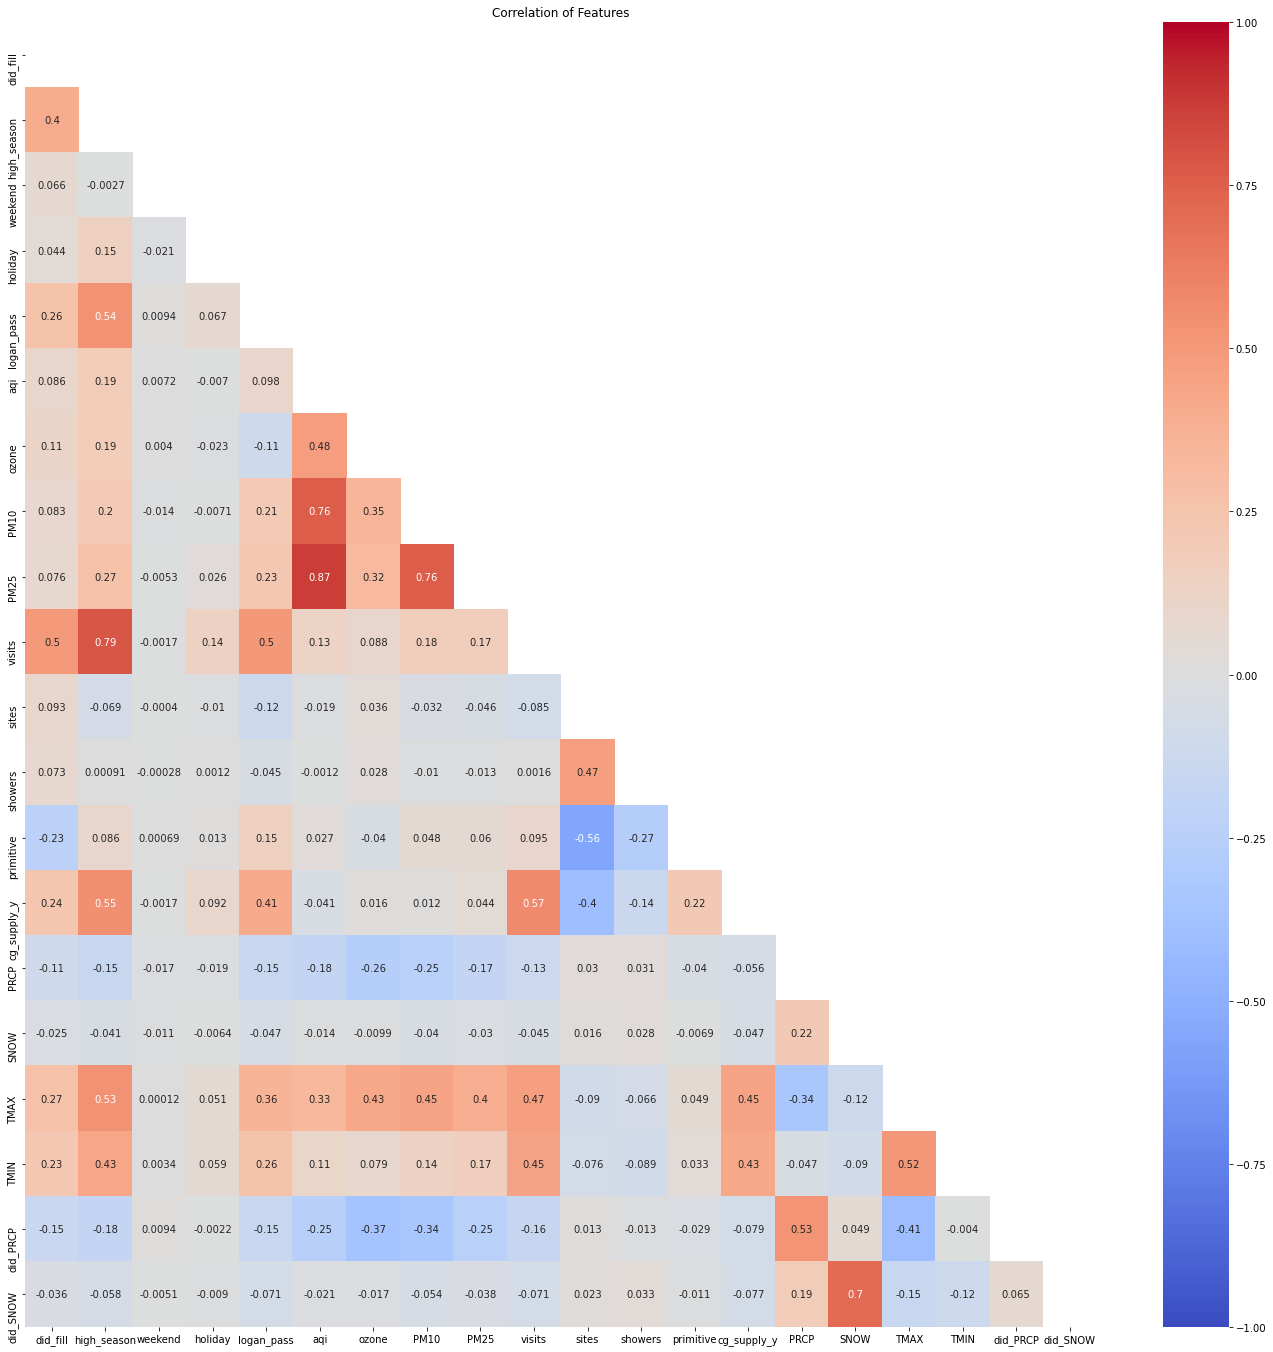

In [58]:
plt.figure(figsize=(24,24))

corr_cont = df[['did_fill'] + features].corr()

plt.title('Correlation of Features');

sns.heatmap(corr_cont,
            annot = True,
            cmap = 'coolwarm', 
            vmin = -1,
            vmax = 1,
            mask=np.triu(corr_cont));

---------



---------



----------


# Classification Models

#### Predict if a campground fills up on a given day

#### Function to Report Results by Category and Model for Classification Models

In [59]:
def Results_by_Category_Class(MODEL,
                              dataframe,
                              feature_list,
                              label_name,
                              group_on = None,
                              sort_by='Test Acc Over Baseline'):
    
    X = dataframe[feature_list]
    y = dataframe[label_name]
    
    model_name = str(MODEL).split('(')[0]
    
    # Create Empty Dictionary to record scores for each category
    grouping_scores = {}

    # Add an 'All' to reflect all data points
    if group_on != None:
        categories = [model_name] + list(dataframe[group_on].unique())
    else:
        categories = [model_name]
    
    for category in categories:
        
        # Don't know a better way to do this
        if category == model_name:
            subset_X, subset_y = X, y
        else:
            subset_X_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_X = X.loc[subset_X_indices]
            subset_y_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_y = y.loc[subset_y_indices]
        
        # Train Test Split specific to this group
        subset_X_train, subset_X_test, subset_y_train, subset_y_test = train_test_split(subset_X, subset_y,
                                                                            random_state = 111,
                                                                            stratify = subset_y)
        # Standard Scale
        sc = StandardScaler()
        subset_X_train = sc.fit_transform(subset_X_train)
        subset_X_test = sc.transform(subset_X_test)

        # Instantiate and Fit Model
        subset_model = MODEL
        subset_model.fit(subset_X_train, subset_y_train)
        
        # Generate Predictions
        subset_predictions_train = subset_model.predict(subset_X_train)
        subset_predictions_test = subset_model.predict(subset_X_test)

        # Confusion Matrix for Classification Metrics
        tn, fp, fn, tp = confusion_matrix(subset_y_test, subset_predictions_test).ravel()

        grouping_scores[category]={
            "Observations":subset_y.shape[0],
            "Incidence":subset_y.sum(),
            "Prevalence":subset_y.mean(),
            "Majority":max(subset_y.mean(),1-subset_y.mean()),
            "Train Acc":subset_model.score(subset_X_train,subset_y_train),
            "Test Acc":subset_model.score(subset_X_test,subset_y_test),
            "Test Acc Over Baseline":subset_model.score(subset_X_test,subset_y_test) - max(subset_y.mean(),1-subset_y.mean()),
#             "Train F1" :f1_score(subset_y_train, subset_predictions_train),
            "Test F1" :f1_score(subset_y_test, subset_predictions_test),
            "Sensitivity" : tp / (tp + fn),
            "Specificity" : tn / (tn + fp),
            "PPV" : tp / (tp + fp),
            "NPV" : tn / (tn + fn)
        }
           
    return np.round(pd.DataFrame(grouping_scores).T,2).sort_values([sort_by],ascending=False)

#### Specify the Dataframe for Classification

In [60]:
# To reset and undo any filters
df_class = df 

# class_filters = (df['month_num']!=5)
# df_class = df_class[class_filters]

#### Identify X and y

In [61]:
X = df_class[features]
y = df_class['did_fill']

#### Train Test Split with Stratify

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 111,
                                                   stratify = y)

#### Standard Scaler for Non Pipeline Models

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Logistic Regression Classifier

In [ ]:
logistic_c_model = LogisticRegression(
    penalty = 'l1',
    solver = 'liblinear')

logistic_c_model.fit(X_train_sc,y_train)

logistic_c_model.score(X_test_sc,y_test)

#### View Logistic Coefficients

In [ ]:
# pd.DataFrame(data=np.exp(logistic_c_model.coef_[0]),
#             columns = ['Logistic Regression Coefficient'],
#             index = features).sort_values('Logistic Regression Coefficient',
#                                           ascending=False)

### ADA Boost Classifier

In [ ]:
ada_c_model = AdaBoostClassifier(n_estimators = 150)

ada_c_model.fit(X_train_sc, y_train)

ada_c_model.score(X_test_sc,y_test)

### Support Vector Classifier

In [ ]:
svc_c_model = SVC(C = 1.0)

svc_c_model.fit(X_train_sc, y_train)

svc_c_model.score(X_test_sc,y_test)

### Random Forest Classifier

In [ ]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf',RandomForestClassifier())
])

params = {
    'rf__n_estimators' : [50, 100, 150],
    'rf__max_features': ['auto', 'log2'],
    'rf__max_depth': [5,10,15],
}

gs_rf_c = GridSearchCV(pipe, params,
                       cv = 5, n_jobs = 8,
                       verbose = 1)

gs_rf_c.fit(X_train, y_train)

gs_rf_c.best_params_

In [ ]:
gs_rf_c.score(X_test_sc,y_test)

## Bernoulli Naive Bayes

In [ ]:
bnb_c_model = BernoulliNB()

bnb_c_model.fit(X_train_sc, y_train)

bnb_c_model.score(X_test_sc,y_test)

### Neural Network Classifier

In [ ]:
model_NNClass = Sequential()

model_NNClass.add(Dense(32, activation = 'relu',
                        input_shape = X_train_sc[0].shape))

model_NNClass.add(Dense(8, activation = 'relu'))

model_NNClass.add(Dense(1, activation = 'sigmoid'))

model_NNClass.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics = ['accuracy'])

hist = model_NNClass.fit(X_train_sc, y_train,
                         epochs = 50,
                         batch_size= 512,
                         validation_data = (X_test_sc, y_test),
                         verbose = 0)

#### View Neural Net Loss by Epoch

In [ ]:
plt.plot(hist.history['loss'], label = 'Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()

## Classification Results by Subgroup - Campground

In [64]:
classification_by_campground = Results_by_Category_Class(MODEL = AdaBoostClassifier(n_estimators = 150),
                                                         dataframe = df_class,
                                                         feature_list = features,
                                                         label_name = 'cg_name',
                                                         group_on = 'high_season',
                                                         sort_by = 'Test Acc Over Baseline')

In [65]:
classification_by_campground

Observations  Incidence  Prevalence  Majority  Train Acc  \
1                        15186.0     7079.0        0.47      0.53       0.83   
AdaBoostClassifier       29046.0     8444.0        0.29      0.71       0.87   
0                        13860.0     1365.0        0.10      0.90       0.93   

                    Test Acc  Test Acc Over Baseline  Test F1  Sensitivity  \
1                       0.82                    0.29     0.81         0.79   
AdaBoostClassifier      0.86                    0.16     0.75         0.71   
0                       0.93                    0.02     0.54         0.44   

                    Specificity   PPV   NPV  
1                          0.85  0.82  0.82  
AdaBoostClassifier         0.93  0.80  0.89  
0                          0.98  0.69  0.94

In [ ]:
df.columns.T

In [71]:
classification_by_high_season = Results_by_Category_Class(MODEL = AdaBoostClassifier(n_estimators = 150),
                                                         dataframe = df_class,
                                                         feature_list = features,
                                                         label_name = 'did_fill',
                                                         group_on = 'high_season',
                                                         sort_by = 'Test Acc Over Baseline')

In [72]:
classification_by_high_season.rename(
    index={1:"High Season Months",
           0:"Low Season Months",
          "AdaBoostClassifier":"All Months"})

Observations  Incidence  Prevalence  Majority  Train Acc  \
High Season Months       15186.0     7079.0        0.47      0.53       0.83   
All Months               29046.0     8444.0        0.29      0.71       0.87   
Low Season Months        13860.0     1365.0        0.10      0.90       0.93   

                    Test Acc  Test Acc Over Baseline  Test F1  Sensitivity  \
High Season Months      0.82                    0.29     0.81         0.79   
All Months              0.86                    0.16     0.75         0.71   
Low Season Months       0.93                    0.02     0.54         0.44   

                    Specificity   PPV   NPV  
High Season Months         0.85  0.82  0.82  
All Months                 0.93  0.80  0.89  
Low Season Months          0.98  0.69  0.94

In [76]:
classification_by_year = Results_by_Category_Class(MODEL = AdaBoostClassifier(n_estimators = 150),
                                                         dataframe = df_class,
                                                         feature_list = features,
                                                         label_name = 'did_fill',
                                                         group_on = 'year',
                                                         sort_by = 'Test Acc Over Baseline')

In [87]:
classification_by_year.rename(
    index={"AdaBoostClassifier":"All Years"})

Observations  Incidence  Prevalence  Majority  Train Acc  Test Acc  \
2016             1545.0      773.0        0.50      0.50       0.88      0.88   
2018             1391.0      668.0        0.48      0.52       0.91      0.89   
2017             1467.0      796.0        0.54      0.54       0.93      0.89   
2019             1544.0      711.0        0.46      0.54       0.87      0.86   
2014             1544.0      637.0        0.41      0.59       0.92      0.90   
2015             1479.0      559.0        0.38      0.62       0.91      0.87   
2013             1544.0      563.0        0.36      0.64       0.90      0.88   
2012             1545.0      535.0        0.35      0.65       0.92      0.88   
2010             1544.0      509.0        0.33      0.67       0.92      0.90   
2011             1544.0      443.0        0.29      0.71       0.92      0.89   
2009             1544.0      406.0        0.26      0.74       0.93      0.90   
All Years       29046.0     8444.0        0.29      0.71       0.87      0.86   
2008             1545.0      242.0        0.16      0.84       0.95      0.93   
2006             1544.0      252.0        0.16      0.84       0.93      0.92   
2002             1544.0      279.0        0.18      0.82       0.94      0.90   
2000             1545.0      198.0        0.13      0.87       0.95      0.93   
2005             1544.0      263.0        0.17      0.83       0.93      0.89   
2001             1544.0      233.0        0.15      0.85       0.94      0.91   
2007             1544.0      185.0        0.12      0.88       0.95      0.91   
2004             1545.0      192.0        0.12      0.88       0.94      0.90   

           Test Acc Over Baseline  Test F1  Sensitivity  Specificity   PPV  \
2016                         0.38     0.88         0.87         0.90  0.89   
2018                         0.37     0.88         0.86         0.92  0.91   
2017                         0.35     0.90         0.92         0.85  0.88   
2019                         0.32     0.85         0.83         0.89  0.87   
2014                         0.31     0.88         0.89         0.90  0.86   
2015                         0.25     0.83         0.84         0.88  0.81   
2013                         0.24     0.83         0.86         0.89  0.81   
2012                         0.23     0.84         0.86         0.90  0.82   
2010                         0.23     0.85         0.83         0.93  0.86   
2011                         0.18     0.80         0.77         0.94  0.84   
2009                         0.16     0.81         0.80         0.94  0.82   
All Years                    0.16     0.75         0.71         0.93  0.80   
2008                         0.09     0.75         0.66         0.98  0.89   
2006                         0.08     0.71         0.62         0.98  0.83   
2002                         0.08     0.70         0.66         0.95  0.75   
2000                         0.06     0.70         0.62         0.98  0.82   
2005                         0.06     0.63         0.56         0.96  0.73   
2001                         0.06     0.65         0.53         0.98  0.82   
2007                         0.03     0.63         0.61         0.96  0.65   
2004                         0.02     0.58         0.56         0.95  0.60   

            NPV  
2016       0.87  
2018       0.87  
2017       0.90  
2019       0.86  
2014       0.92  
2015       0.90  
2013       0.92  
2012       0.92  
2010       0.92  
2011       0.91  
2009       0.93  
All Years  0.89  
2008       0.94  
2006       0.93  
2002       0.93  
2000       0.95  
2005       0.91  
2001       0.92  
2007       0.95  
2004       0.94

## Classification Model Comparison

#### Non Neural Network Models

In [ ]:
# List out the classification models
classification_model_set = [logistic_c_model,
                           ada_c_model,
                           svc_c_model,
                           gs_rf_c.best_estimator_,
                           bnb_c_model]

# Create an emtpy dataframe
model_class_summary = pd.DataFrame()

# For each model in our list record its performance and add it to the dataframe
for i in classification_model_set:
    model_class_summary = pd.concat([model_class_summary
                                     ,Results_by_Category_Class(MODEL = i,
                                                                dataframe = df_class,
                                                                feature_list = features,
                                                                label_name = 'did_fill',
                                                                group_on = None,
                                                                sort_by = 'Test Acc Over Baseline') ]) 
# Return the dataframe
model_class_summary

#### Clean up Resultant Dataframe

In [ ]:
classification_summary = model_class_summary[
    ['Observations','Prevalence','Majority','Train Acc','Test Acc','Test Acc Over Baseline','Test F1']
].rename(index={'Pipeline':'RandomForest'})

In [ ]:
classification_summary = model_class_summary[
    ['Observations','Prevalence','Majority','Train Acc','Test Acc','Test Acc Over Baseline','Test F1','PPV','NPV']
].rename(index={'Pipeline':'RandomForest'})

In [ ]:
classification_summary

#### Create Results for Neural Net Model (.predict vs .predict_classes)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, model_NNClass.predict_classes(X_test_sc)).ravel()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, model_NNClass.predict_classes(X_test_sc)).ravel()

NNClass_Results = {
    "Observations":y.shape[0],
    "Prevalence":y.mean(),
    "Majority":max(y.mean(),1-y.mean()),
    'Train Acc':metric.accuracy_score(y_train,model_NNClass.predict_classes(X_train_sc)),
    'Test Acc':metric.accuracy_score(y_test,model_NNClass.predict_classes(X_test_sc)),
    'Test Acc Over Baseline':metric.accuracy_score(y_test,model_NNClass.predict_classes(X_test_sc)) - max(y.mean(),1-y.mean()),
    'Test F1':f1_score(y_test,model_NNClass.predict_classes(X_test_sc)),
    "PPV" : tp / (tp + fp),
    "NPV" : tn / (tn + fn)
}

nnc_dict = pd.DataFrame(NNClass_Results,index=['Neural Net Classifer'])

#### Add Neural Networks to Dataframe

In [ ]:
results_df_classification = np.round(classification_summary.append(nnc_dict),2).sort_values('Test Acc Over Baseline',ascending=False)

In [ ]:
results_df_classification.to_clipboard()

## Export Tables to CSV to Format

In [ ]:
results_df_classification.to_csv("../presentation_graphics/classification_table.csv")

classification_by_campground.to_csv("../presentation_graphics/classification_table_campgroundnames.csv")

---------

---------

----------


# Regression Models

#### Predict at what time of day a campground fills up

#### Function to Report Results by Category and Model for Regression Models

In [ ]:
def Results_by_Category_Reg(MODEL, dataframe, feature_list, label_name, group_on,sort_by):
    
    X = dataframe[feature_list]
    y = dataframe[label_name]
    
    model_name = str(MODEL).split('(')[0]
    
    # Create Empty Dictionary to record scores for each category
    grouping_scores = {}

    # Add an 'All' to reflect all data points
    if group_on != None:
        categories = [model_name] + list(dataframe[group_on].unique())
    else:
        categories = [model_name]
    
    for category in categories:
        
        # Don't know a better way to do this
        if category == model_name:
            subset_X, subset_y = X, y
        else:
            subset_X_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_X = X.loc[subset_X_indices]
            subset_y_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_y = y.loc[subset_y_indices]
        
        # Train Test Split specific to this group
        subset_X_train, subset_X_test, subset_y_train, subset_y_test = train_test_split(subset_X, subset_y,
                                                                            random_state = 111)
        # Standard Scale
        sc = StandardScaler()
        subset_X_train = sc.fit_transform(subset_X_train)
        subset_X_test = sc.transform(subset_X_test)

        # Instantiate and Fit Model
        subset_model = MODEL
        subset_model.fit(subset_X_train, subset_y_train)
        
        # Generate Predictions
        subset_predictions_train = subset_model.predict(subset_X_train)
        subset_predictions_test = subset_model.predict(subset_X_test)

        grouping_scores[category]={
            "Observations":subset_y.shape[0],
            "Y_Bar":subset_y.mean(),
            "StdDev":subset_y.std(),
            "Train R2":metric.r2_score(subset_y_train,subset_predictions_train),
            "Test R2":metric.r2_score(subset_y_test,subset_predictions_test),
            "Train RMSE":metric.mean_squared_error(subset_y_train,subset_predictions_train,squared=False),
            "Test RMSE":metric.mean_squared_error(subset_y_test,subset_predictions_test,squared=False),
            "Train MAE":metric.mean_absolute_error(subset_y_train,subset_predictions_train),
            "Test MAE":metric.mean_absolute_error(subset_y_test,subset_predictions_test)
        }
         
    return np.round(pd.DataFrame(grouping_scores).T,2).sort_values([sort_by],ascending=False)

### Function to Plot Residuals

In [ ]:
def plot_residuals(true_values, predicted_values, model_text = 'model'):
    if true_values.shape != predicted_values.shape:
        predicted_values = predicted_values.reshape(true_values.shape)
    errors = np.array(true_values) - np.array(predicted_values)
    plt.figure(figsize=(9,9))    
    plt.scatter(predicted_values, errors, s = 5)
    plt.axhline(0, color = 'red')
    plt.xlabel("Predictions", fontsize = 20)
    plt.ylabel("Residuals (Actual - Predicted)", fontsize = 20)
    plt.title(f'Residual Plot for {model_text}', fontsize = 24);
    

#### Define the dataframe of interest for Regression

In [ ]:
# To reset and undo any filters
df_regress = df[df['did_fill']==1]

# regress_filters = (df_regress['month_num']!=5)

# df_regress = df_regress[regress_filters]

#### Define X and Y for Regression with suffix 'r' to denote Regression

In [ ]:
Xr = df_regress[features]
yr = df_regress['hours_after_midnight']

#### Train Test Split of same

In [ ]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr,
                                                   random_state = 111)

#### Standard Scaler

In [ ]:
sc_reg = StandardScaler()
Xr_train_sc = sc_reg.fit_transform(Xr_train)
Xr_test_sc = sc_reg.transform(Xr_test)

### Neural Network Regression

In [ ]:
model_NNReg = Sequential()

model_NNReg.add(Dense(32, activation = 'relu',
                      input_shape = Xr_train_sc[0].shape))

model_NNReg.add(Dense(8, activation = 'relu'))

model_NNReg.add(Dense(1, activation = None))

model_NNReg.compile(loss = 'mean_squared_error',
                    optimizer = 'adam')

hist = model_NNReg.fit(Xr_train_sc, yr_train,
                       epochs = 50,
                       batch_size= 512,
                       validation_data = (Xr_test_sc, yr_test),
                       verbose = 0)

print(f'train score {metric.r2_score(yr_train,model_NNReg.predict(Xr_train_sc))}, \ntest score {metric.r2_score(yr_test,model_NNReg.predict(Xr_test_sc))}')

### Linear Regression via Sklearn

In [ ]:
linear = LinearRegression()
linear.fit(Xr_train_sc,yr_train)
print(f'train score {linear.score(Xr_train_sc,yr_train)}')
print(f'test score {linear.score(Xr_test_sc,yr_test)}')

### Ridge Regression via Sklearn

In [ ]:
ridge_model = Ridge()
ridge_model.fit(Xr_train_sc,yr_train)
print(f'train score {ridge_model.score(Xr_train_sc,yr_train)}')
print(f'test score {ridge_model.score(Xr_test_sc,yr_test)}')

### Statsmodel - Ordinary Least Squares

In [ ]:
model_X = Xr_train
model_X = sm.add_constant(model_X)
model_y = yr_train
model_OLS = sm.OLS(model_y, model_X).fit()


plot_residuals(yr_test,
               model_OLS.predict(sm.add_constant(Xr_test)),
              'Stats Model OLS')

model_OLS.summary()

## Statsmodels - Gamma Regression

In [ ]:
sm_X = Xr_train
sm_X = sm.add_constant(sm_X)
sm_y = yr_train
gamma_model = sm.GLM(sm_y, sm_X, family = sm.families.Gamma(link = sm.families.links.log)).fit()

gamma_train_preds = gamma_model.predict(sm.add_constant(Xr_train))
gamma_test_preds = gamma_model.predict(sm.add_constant(Xr_test))

plot_residuals(yr_test,
               gamma_test_preds,
              'Gamma Regression')

gamma_model.summary()

## Regression Results by Subgroup - Campground Name

In [ ]:
regression_by_campground = Results_by_Category_Reg(MODEL = SVR(),
                                                    dataframe = df_regress,
                                                    feature_list = features,
                                                    label_name = 'hours_after_midnight',
                                                    group_on = 'cg_name',
                                                    sort_by = 'Test R2')

regression_by_campground

## Regression Model Comparison

In [ ]:
regression_model_set = [LinearRegression(),
                        Ridge(alpha = 1.0),
                        SVR(),
                        AdaBoostRegressor(n_estimators = 100),
                        KNeighborsRegressor(),
                        model_NNReg]

model_comparison = pd.DataFrame()

for i in regression_model_set:
    model_comparison = pd.concat([model_comparison,
                              Results_by_Category_Reg(MODEL = i,
                                dataframe = df_regress,
                                feature_list = features,
                                label_name = 'hours_after_midnight',
                                group_on = None,
                                sort_by = 'Test R2') ])


#### Create same Metrics for Gamma GLM (Statsmodel instead of Sklearn)

In [ ]:
gamma_report = {
    "Observations":yr.shape[0],
    "Y_Bar":yr.mean(),
    "StdDev":yr.std(),
    "Train R2":metric.r2_score(yr_train,gamma_train_preds),
    "Test R2":metric.r2_score(yr_test,gamma_test_preds),
    "Train RMSE":metric.mean_squared_error(yr_train,gamma_train_preds,squared=False),
    "Test RMSE":metric.mean_squared_error(yr_test,gamma_test_preds,squared=False),
    "Train MAE":metric.mean_absolute_error(yr_train,gamma_train_preds),
    "Test MAE":metric.mean_absolute_error(yr_test,gamma_test_preds)
}

gamma_report_df = np.round(pd.DataFrame(gamma_report,index=['Gamma GLM']),2)

#### Add Gamma to Summary Report

In [ ]:
regression_summary = model_comparison.append(
    gamma_report_df).sort_values(
    'Test R2',ascending=False)

In [ ]:
regression_summary = regression_summary.rename(
    index={[i for i in list(regression_summary.index) if 'tensor' in i][0]:"Neural Net Regressor"}
)[list(gamma_report.keys())]

In [ ]:
regression_summary

## Export Tables to CSV to Format

In [ ]:
# regression_summary.to_csv("../presentation_graphics/regression_table.csv")

# regression_by_campground.to_csv("../presentation_graphics/regression_table_campgroundnames.csv")

------------

-----------

----------

# SVR Deep Dive

In [30]:
df_regress = df[df['did_fill']==1]
cg_select = 'Sprague Creek'
subgroup = (df_regress['cg_name'] == cg_select) & (df_regress['year']>=2010)

In [37]:
def generate_svr_preds(df_regress, feature_subset, subgroup):

    # Create X and Y specific to that subgroup and train-test-split
    X = df_regress.loc[subgroup, feature_subset]
    y = df_regress.loc[subgroup, 'hours_after_midnight']
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=111)

    # Standard Scaler
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    X_sc = sc.transform(X)

    # Instantiate SVR
    svr = SVR()
    svr.fit(X_train_sc, y_train)
    preds_svr = svr.predict(X_sc)

#     print(f'train score {svr.score(X_train_sc,y_train)}')
#     print(f'test score {svr.score(X_test_sc,y_test)}')
    
    return preds_svr

In [42]:
df_svr_dive = df_regress.loc[subgroup,:].copy()
df_svr_dive['svr_date_features'] = generate_svr_preds(df_regress, date_features, subgroup)
df_svr_dive['svr_full_features'] = generate_svr_preds(df_regress, features, subgroup)

df_svr_dive['actual_fill_time'] = df_svr_dive['hours_after_midnight']
df_svr_dive['date_x'] = pd.to_datetime(df_svr_dive['date_x'])
df_svr_dive.set_index('date_x', inplace=True)

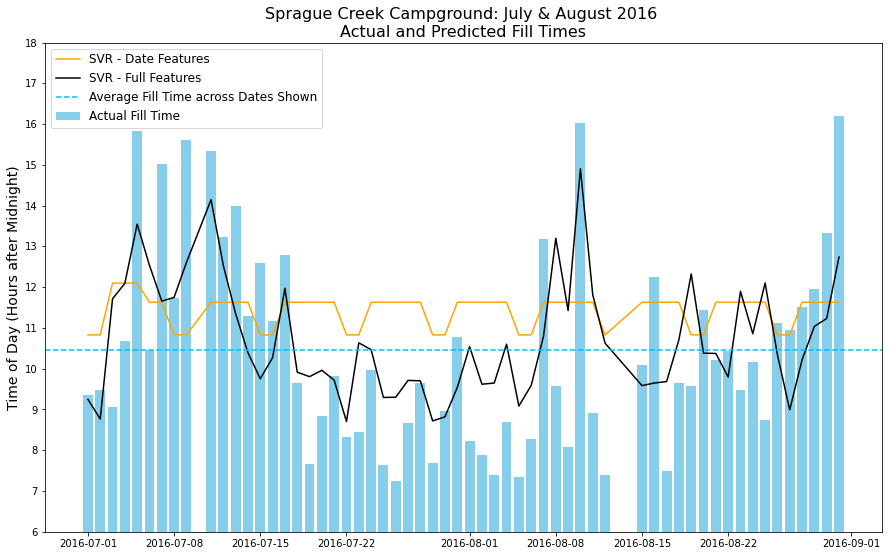

In [47]:
year_filter = 2016
cg_filter = cg_select

df_to_plot = df_svr_dive.loc[(df_svr_dive['year']==year_filter) & (df_svr_dive['high_season']==1)
    ,['actual_fill_time', 'svr_date_features', 'svr_full_features']]

plt.figure(figsize=(15,9))

plt.title(f'{cg_filter} Campground: July & August {year_filter} \nActual and Predicted Fill Times',
          fontsize = 16)

plt.yticks(range(6,19))
plt.ylim(6,18)
plt.ylabel('Time of Day (Hours after Midnight)',
           fontsize = 14)

plt.bar(x = df_to_plot.index, height = df_to_plot['actual_fill_time'],
       label = 'Actual Fill Time',
       color = 'skyblue')

plt.plot(df_to_plot['svr_date_features'],
         label = 'SVR - Date Features',
         color = 'orange')

plt.plot(df_to_plot['svr_full_features'],
        label = 'SVR - Full Features',
        color = 'black')

plt.axhline(df_to_plot['actual_fill_time'].mean(), ls='--',
           label = 'Average Fill Time across Dates Shown',
           color = 'deepskyblue')
plt.legend(fontsize = 12);

# plt.plot(df_to_plot['actual_fill_time'],
#          label = 'Actual Fill Time',
#          color = 'skyblue')

In [43]:
df_svr_dive

cg_name  did_fill  available time_24  hours_after_midnight  \
date_x                                                                         
2010-06-12  Sprague Creek         1          1   19:37                 19.62   
2010-06-22  Sprague Creek         1          1   17:40                 17.67   
2010-06-23  Sprague Creek         1          1   19:15                 19.25   
2010-06-24  Sprague Creek         1          1   18:46                 18.77   
2010-06-28  Sprague Creek         1          1   17:21                 17.35   
...                   ...       ...        ...     ...                   ...   
2019-09-08  Sprague Creek         1          1   11:08                 11.13   
2019-09-10  Sprague Creek         1          1   15:43                 15.72   
2019-09-11  Sprague Creek         1          1   12:15                 12.25   
2019-09-12  Sprague Creek         1          1   11:41                 11.68   
2019-09-13  Sprague Creek         1          1   11:45                 11.75   

            year  month_num month_text  day_of_year  day_of_month  ...  \
date_x                                                             ...   
2010-06-12  2010          6        Jun          163            12  ...   
2010-06-22  2010          6        Jun          173            22  ...   
2010-06-23  2010          6        Jun          174            23  ...   
2010-06-24  2010          6        Jun          175            24  ...   
2010-06-28  2010          6        Jun          179            28  ...   
...          ...        ...        ...          ...           ...  ...   
2019-09-08  2019          9        Sep          251             8  ...   
2019-09-10  2019          9        Sep          253            10  ...   
2019-09-11  2019          9        Sep          254            11  ...   
2019-09-12  2019          9        Sep          255            12  ...   
2019-09-13  2019          9        Sep          256            13  ...   

           cg_supply_y  PRCP  SNOW  TMAX  TMIN  did_PRCP  did_SNOW  \
date_x                                                               
2010-06-12         886  0.00   0.0  70.0  35.0         0         0   
2010-06-22         973  0.10   0.0  62.0  49.0         1         0   
2010-06-23         973  0.00   0.0  74.0  43.0         0         0   
2010-06-24         973  0.00   0.0  78.0  47.0         0         0   
2010-06-28         973  0.00   0.0  82.0  47.0         0         0   
...                ...   ...   ...   ...   ...       ...       ...   
2019-09-08         809  0.00   0.0  73.0  49.0         0         0   
2019-09-10         809  0.11   0.0  59.0  47.0         1         0   
2019-09-11         809  0.00   0.0  64.0  46.0         0         0   
2019-09-12         809  0.00   0.0  64.0  42.0         0         0   
2019-09-13         809  0.01   0.0  68.0  44.0         1         0   

            svr_date_features  svr_full_features  actual_fill_time  
date_x                                                              
2010-06-12          16.449636          17.228329             19.62  
2010-06-22          17.120188          18.499317             17.67  
2010-06-23          17.120188          18.168661             19.25  
2010-06-24          15.820033          16.596137             18.77  
2010-06-28          15.820033          15.699851             17.35  
...                       ...                ...               ...  
2019-09-08          15.820033          15.111751             11.13  
2019-09-10          15.820033          17.476557             15.72  
2019-09-11          15.820033          15.433598             12.25  
2019-09-12          15.820033          16.114453             11.68  
2019-09-13          14.813187          15.510449             11.75  

[819 rows x 39 columns]

-------------

# Graphics

--------

In [ ]:
df.loc[df['high_season']==1,:].groupby('cg_name').sum()

In [ ]:
cg_select = 'Sprague Creek'
subgroup = (df_regress['cg_name'] == cg_select)



#### Identify the subgroup of interest

In [90]:
cg_select = 'Sprague Creek'

subgroup = (df_regress['cg_name'] == cg_select) #& (df_regress['year']==2016)

# Create X and Y specific to that subgroup and train-test-split
X = df_regress.loc[subgroup, features]
y = df_regress.loc[subgroup, 'hours_after_midnight']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=111)

# Standard Scaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_sc = sc.transform(X)

In [89]:
feature_subset = date_features

# Create X and Y specific to that subgroupd and train-test-split
X = df_regress.loc[subgroup, feature_subset]
y = df_regress.loc[subgroup, 'hours_after_midnight']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=111)

# Standard Scaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_sc = sc.transform(X)

# Instantiate SVR
svr_date = SVR()
svr_date.fit(X_train_sc, y_train)
preds_svr_date = svr_date.predict(X_sc)

print(f'train score {svr_date.score(X_train_sc,y_train)}')
print(f'test score {svr_date.score(X_test_sc,y_test)}')

train score 0.21141461775816994
test score 0.2289210386617332


In [91]:
svr = SVR()
svr.fit(X_train_sc, y_train)
preds_svr = svr.predict(X_sc)

print(f'train score {svr.score(X_train_sc,y_train)}')
print(f'test score {svr.score(X_test_sc,y_test)}')

train score 0.5309767142210391
test score 0.5017960381004137


#### Support Vector Regression

#### Vanilla Linear

In [92]:
lin_x = X_train
lin_x = sm.add_constant(lin_x)
lin_y = y_train

lin_model = sm.OLS(lin_y, lin_x).fit()

lin_train_preds = lin_model.predict(sm.add_constant(X_train))
lin_test_preds = lin_model.predict(sm.add_constant(X_test))
preds_lin = lin_model.predict(sm.add_constant(X))

print(f'train score {metric.r2_score(y_train, lin_train_preds)}')
print(f'test score {metric.r2_score(y_test, lin_test_preds)}')

train score 0.48736619299081185
test score 0.4799775131068842


In [93]:
lin_model.summary()

C:\Users\zacha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\zacha\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\zacha\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\zacha\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\zacha\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     hours_after_midnight   R-squared:                       0.487
Model:                              OLS   Adj. R-squared:                  0.481
Method:                   Least Squares   F-statistic:                     73.48
Date:                  Sun, 02 May 2021   Prob (F-statistic):          4.97e-146
Time:                          17:19:46   Log-Likelihood:                -2530.0
No. Observations:                  1097   AIC:                             5090.
Df Residuals:                      1082   BIC:                             5165.
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
high_season     0.3105      0.268      1.157      0.247      -0.216       0.837
weekend        -0.6236      0.161     -3.874      0.000      -0.939      -0.308
holiday         1.0919      0.425      2.568      0.010       0.257       1.926
logan_pass     -0.8500      0.291     -2.918      0.004      -1.422      -0.278
aqi            -0.0163      0.011     -1.528      0.127      -0.037       0.005
ozone           0.0114      0.014      0.793      0.428      -0.017       0.040
PM10            0.0027      0.010      0.257      0.797      -0.018       0.023
PM25            0.0210      0.008      2.633      0.009       0.005       0.037
visits      -1.281e-05   5.98e-07    -21.419      0.000    -1.4e-05   -1.16e-05
sites           0.9053      0.044     20.472      0.000       0.819       0.992
showers       6.62e-16   2.46e-16      2.689      0.007    1.79e-16    1.15e-15
primitive   -5.973e-17   3.87e-17     -1.543      0.123   -1.36e-16    1.62e-17
cg_supply_y     0.0048      0.001      4.813      0.000       0.003       0.007
PRCP            0.7037      0.729      0.965      0.335      -0.727       2.135
SNOW         1.213e-16   1.64e-16      0.738      0.460   -2.01e-16    4.43e-16
TMAX           -0.0615      0.014     -4.405      0.000      -0.089      -0.034
TMIN           -0.0202      0.015     -1.378      0.168      -0.049       0.009
did_PRCP        0.3951      0.225      1.757      0.079      -0.046       0.836
did_SNOW             0          0        nan        nan           0           0
==============================================================================
Omnibus:                       36.393   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.195
Skew:                           0.457   Prob(JB):                     3.08e-09
Kurtosis:                       3.145   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Gamma Regression

In [94]:
sm_X = X_train
sm_X = sm.add_constant(sm_X)
sm_y = y_train
gamma_model = sm.GLM(sm_y, sm_X, family = sm.families.Gamma(link = sm.families.links.log)).fit()

gamma_train_preds = gamma_model.predict(sm.add_constant(X_train))
gamma_test_preds = gamma_model.predict(sm.add_constant(X_test))
preds_gamma = gamma_model.predict(sm.add_constant(X))

print(f'train score {metric.r2_score(y_train,gamma_train_preds)}')
print(f'test score {metric.r2_score(y_test,gamma_test_preds)}')

train score 0.4664163514442141
test score 0.45322745996496494


C:\Users\zacha\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


In [95]:
# gamma_model.summary()

#### Create Dataframe to view these Predictions

In [96]:
df_subgroup = df_regress.loc[subgroup,:].copy()
df_subgroup['svr_predictions'] = preds_svr
# df_subgroup['gamma_predictions'] = preds_gamma
# df_subgroup['OLS_predictions'] = preds_lin
df_subgroup['actual_fill_time'] = df_subgroup['hours_after_midnight']

df_subgroup['date_x'] = pd.to_datetime(df_subgroup['date_x'])
df_subgroup.set_index('date_x', inplace=True)

#### The Plot

In [97]:
year_filter = 2016
cg_filter = cg_select

df_to_plot = df_subgroup.loc[(df_subgroup['year']==year_filter) & (df_subgroup['high_season']==1)
    ,['actual_fill_time', 'svr_predictions', 'gamma_predictions']]

plt.figure(figsize=(15,9))

plt.title(f'{cg_filter} Campground: July & August {year_filter} \nActual and Predicted Fill Times',
          fontsize = 16)

plt.yticks(range(6,19))
plt.ylim(6,18)
plt.ylabel('Time of Day (Hours after Midnight)',
           fontsize = 14)

plt.bar(x = df_to_plot.index, height = df_to_plot['actual_fill_time'],
       label = 'Actual Fill Time',
       color = 'skyblue')

plt.plot(df_to_plot['svr_predictions'],
         label = 'Support Vector Regression',
         color = 'black')

plt.plot(df_to_plot['gamma_predictions'],
        label = 'Gamma General Linear Model',
        color = 'orange')

plt.axhline(df_to_plot['actual_fill_time'].mean(), ls='--',
           label = 'Average Fill Time across Dates Shown',
           color = 'deepskyblue')
plt.legend(fontsize = 12);

# plt.plot(df_to_plot['actual_fill_time'],
#          label = 'Actual Fill Time',
#          color = 'skyblue')

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [98]:
year_filter = 2016
cg_filter = cg_select

df_to_plot = df_subgroup.loc[
    (df_subgroup['year']==year_filter)
    & (df_subgroup['high_season']==1)
    ,['actual_fill_time',
      'svr_predictions',
      'gamma_predictions']]

plt.figure(figsize=(15,9))

plt.title(f'{cg_filter} Campground: July & August {year_filter} \nActual and Predicted Fill Times',
          fontsize = 16)

plt.yticks(range(6,19))
plt.ylim(6,18)
plt.ylabel('Time of Day (Hours after Midnight)',
           fontsize = 14)

plt.bar(x = df_to_plot.index, height = df_to_plot['actual_fill_time'],
       label = 'Actual Fill Time',
       color = 'skyblue')

plt.plot(df_to_plot['svr_predictions'],
         label = 'Support Vector Regression',
         color = 'black')

plt.plot(df_to_plot['gamma_predictions'],
        label = 'Gamma General Linear Model',
        color = 'orange')

plt.axhline(df_to_plot['actual_fill_time'].mean(), ls='--',
           label = 'Average Fill Time across Dates Shown',
           color = 'deepskyblue')
plt.legend(fontsize = 12);

# plt.plot(df_to_plot['actual_fill_time'],
#          label = 'Actual Fill Time',
#          color = 'skyblue')

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [ ]:
df_subgroup

### Graphic for AQI at Many Glacier September 2017

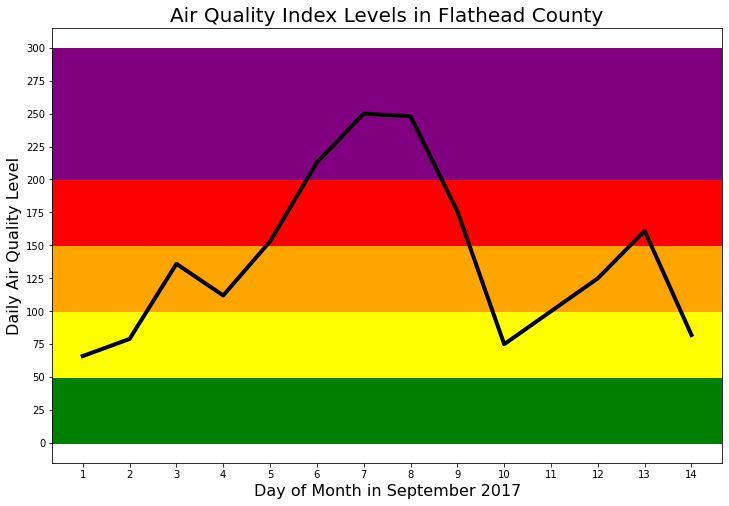

In [99]:
extract_to_plot = df.loc[(df['cg_name']=='Many Glacier')
                         & (df['month_num']==9)
                         & (df['year']==2017)
                         & (df['day_of_month']<15)].set_index('day_of_month')['aqi']
plt.figure(figsize=(12,8))


plt.plot(extract_to_plot,
        color = 'black',
        lw = 4)

plt.xlabel('Day of Month in September 2017',fontsize=16)
plt.ylabel('Daily Air Quality Level',fontsize=16)
plt.title('Air Quality Index Levels in Flathead County',fontsize=20)

plt.axhspan(0,50,color='green',)
plt.axhspan(50,100,color='yellow')
plt.axhspan(100,150,color='orange')
plt.axhspan(150,200,color='red')
plt.axhspan(200,300,color='purple')

plt.xticks(np.arange(1,15,1))
plt.yticks(np.arange(0,325,25));


### Graphic for Annual Visitors vs Fill Days

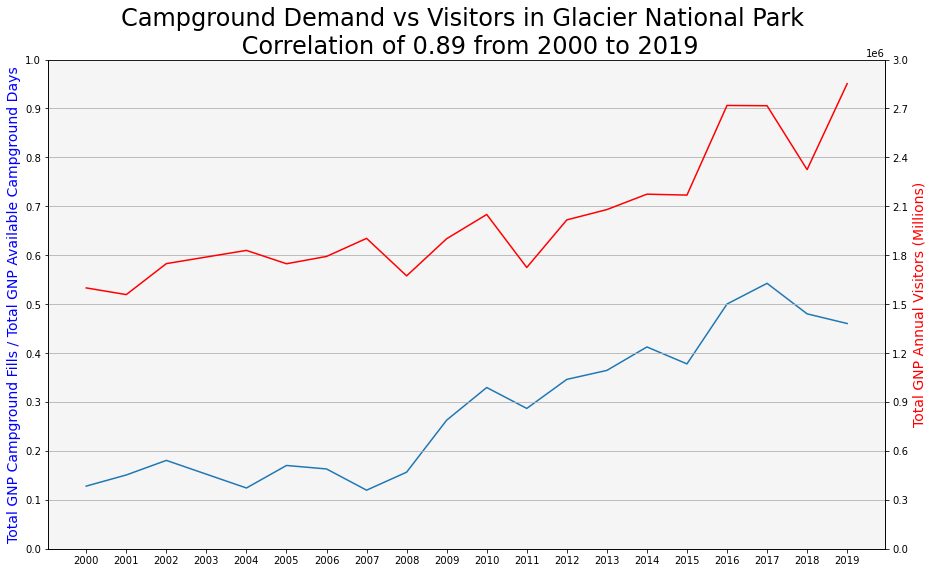

In [100]:
yearly_visits = df.loc[(df['cg_name']=='Apgar') & (df['day_of_month']==1)].groupby('year')['visits'].sum()
yearly_fills = df.groupby('year')['did_fill'].mean()
the_corr = np.round(np.corrcoef(yearly_visits,yearly_fills)[0][1],2)

fig_dims = (15,9)
fig, ax1 = plt.subplots(figsize = fig_dims)

ax2 = ax1.twinx()
ax2.plot(yearly_visits,color = 'red')
ax1.plot(yearly_fills)

ax2.set_yticks(range(0,3_000_001,300_000))
ax1.set_yticks(np.round([0.1*i for i in range(0,11)],2))

ax2.set_ylabel('Total GNP Annual Visitors (Millions)',fontsize = 14,color = 'red')
ax1.set_ylabel('Total GNP Campground Fills / Total GNP Available Campground Days',fontsize = 14,color='blue')
ax1.set_xticks(range(2000,2020))

plt.grid()
ax1.set_facecolor(color = 'whitesmoke')

plt.title(f'Campground Demand vs Visitors in Glacier National Park \n Correlation of {the_corr} from 2000 to 2019',fontsize = 24);


### Graphic for Fill Time Distribution

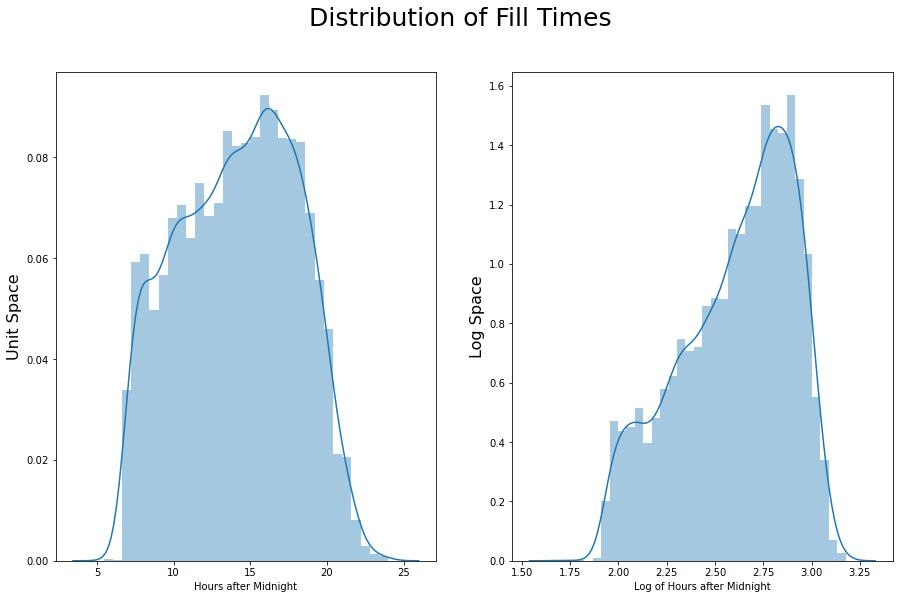

In [113]:
series_to_plot = df_regress['hours_after_midnight']

fig_dims = (15,9)


fig,ax = plt.subplots(1,2,
                     figsize = fig_dims)

fig.suptitle("Distribution of Fill Times",fontsize = 25)

sns.distplot(series_to_plot, ax = ax[0])
sns.distplot(np.log(series_to_plot), ax = ax[1])

ax[0].set_ylabel('Unit Space',fontsize = 16)
ax[1].set_ylabel('Log Space',fontsize = 16)
ax[0].set_xlabel('Hours after Midnight')
ax[1].set_xlabel('Log of Hours after Midnight');

### Air Quality Plot to Identify Prominent Fires

In [ ]:
daily_air_quality

In [ ]:
daily_air_quality.index.year

In [ ]:
daily_air_quality

In [ ]:
daily_air_quality.resample('W').max()

In [ ]:
daily_air_quality = df.loc[(df['cg_name']=='Apgar') & (df['year']==2017),['date_x','aqi']]

daily_air_quality['date_x']=pd.to_datetime(daily_air_quality['date_x'])

daily_air_quality.set_index('date_x',inplace=True)

plt.figure(figsize=(16,12))

plt.axhspan(0,50,color='green',)
plt.axhspan(50,100,color='yellow')
plt.axhspan(100,150,color='orange')
plt.axhspan(150,200,color='red')
plt.axhspan(200,300,color='purple')



# daily_air_quality.set_index('Month',inplace=True)

# plt.xticks(np.arange(2000,2020))

plt.plot(daily_air_quality.resample('W').max());